In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import importlib

from tqdm import tqdm_notebook

In [2]:
try: importlib.reload(msp)
except: import ModSimPy as msp

# Подготовка данных

In [3]:
calls_stat_ds = pd.DataFrame()
calls_stat_ds['regular_clients'] = [87, 165, 236, 323, 277, 440, 269, 342, 175, 273, 115,  56]
calls_stat_ds['vip_clients'] = [89, 243, 221, 180, 301, 490, 394, 347, 240, 269, 145,  69]
calls_stat_ds['silver_clients'] = 0.68*calls_stat_ds['vip_clients']
calls_stat_ds['gold_clients'] = calls_stat_ds['vip_clients']-calls_stat_ds['silver_clients']
for f in calls_stat_ds.columns:
    calls_stat_ds[f+'_per_sec'] = calls_stat_ds[f]/3600
calls_stat_ds.index = range(7,19)
print('Частота звонков')
calls_stat_ds

Частота звонков


,regular_clients,vip_clients,silver_clients,gold_clients,regular_clients_per_sec,vip_clients_per_sec,silver_clients_per_sec,gold_clients_per_sec
7,87,89,60.52,28.48,0.024167,0.024722,0.016811,0.007911
8,165,243,165.24,77.76,0.045833,0.067500,0.045900,0.021600
9,236,221,150.28,70.72,0.065556,0.061389,0.041744,0.019644
10,323,180,122.40,57.60,0.089722,0.050000,0.034000,0.016000
11,277,301,204.68,96.32,0.076944,0.083611,0.056856,0.026756
12,440,490,333.20,156.80,0.122222,0.136111,0.092556,0.043556
13,269,394,267.92,126.08,0.074722,0.109444,0.074422,0.035022
14,342,347,235.96,111.04,0.095000,0.096389,0.065544,0.030844
15,175,240,163.20,76.80,0.048611,0.066667,0.045333,0.021333
16,273,269,182.92,86.08,0.075833,0.074722,0.050811,0.023911


# Модель 1

In [4]:
def init_state(system):
    state = msp.State(
        time_cur=system.time_start,
        lines_time_to_free=np.array([0 for x in range(system.n_lines)]),
        n_missed_clients = {'regular':0, 'silver':0, 'gold':0})
    return state

In [5]:
def to_next_timestep(system, state, tqdm):
    state.time_cur += system.timedelta
    state.lines_time_to_free = np.maximum(state.lines_time_to_free-system.timedelta.seconds, 0)
    tqdm.update(system.timedelta.seconds)

In [6]:
def get_n_busy_lines(lines_time_to_free):
    return (lines_time_to_free>0).sum()

In [7]:
def calc_statistic(state):
    data = pd.Series({
        'busy_lines': get_n_busy_lines(state.lines_time_to_free),
        'missed_clients_regular':state.n_missed_clients['regular']},
        name=state.time_cur)
    return data

In [8]:
def step(system, state):
    regular_p = system.calls_stat.loc[state.time_cur.hour, 'regular_clients_per_sec']
    regc = msp.flip(regular_p)
    if regc:
        if get_n_busy_lines(state.lines_time_to_free)<system.n_lines:
            line_to_occupy = (state.lines_time_to_free==0).argmax()
            state.lines_time_to_free[line_to_occupy] = system.time_to_serve
        else:
            state.n_missed_clients['regular'] += 1

In [9]:
def run_simulation(system):
    state = init_state(system)
    
    results_frame = msp.TimeFrame()
    
    tqdm = tqdm_notebook(total=(system.time_end-system.time_start).seconds//system.timedelta.seconds)
    while state.time_cur<system.time_end:
        step(system, state)
        results_frame = results_frame.append(calc_statistic(state))
        to_next_timestep(system, state, tqdm)
    tqdm.close()

    return results_frame

In [10]:
system = msp.System(time_start=datetime.datetime(2018,1,1,7,0),
                #time_end=datetime.datetime(2018,1,1,19,0),
                time_end=datetime.datetime(2018,1,1,9,0),
                timedelta = datetime.timedelta(seconds=1),
                n_lines = 50,
                calls_stat=calls_stat_ds,
                time_to_serve=120, # seconds
                client_types = ['regular']
                )

In [11]:
results = run_simulation(system)

A Jupyter Widget

In [12]:
results.head()

,busy_lines,missed_clients_regular
2018-01-01 07:00:00,0.0,0.0
2018-01-01 07:00:01,0.0,0.0
2018-01-01 07:00:02,0.0,0.0
2018-01-01 07:00:03,0.0,0.0
2018-01-01 07:00:04,0.0,0.0


In [13]:
results.tail()

,busy_lines,missed_clients_regular
2018-01-01 08:59:55,6.0,0.0
2018-01-01 08:59:56,6.0,0.0
2018-01-01 08:59:57,6.0,0.0
2018-01-01 08:59:58,6.0,0.0
2018-01-01 08:59:59,6.0,0.0


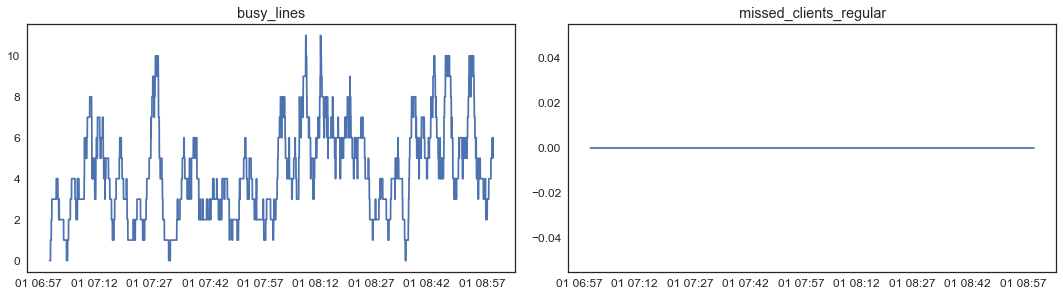

In [14]:
plt.figure(figsize=(15,8))
for idx,f in enumerate(results.columns):
    plt.subplot(len(results.columns)//2+1, 2, idx+1)
    plt.title(f)
    plt.plot(results[f])
plt.tight_layout()
plt.show()

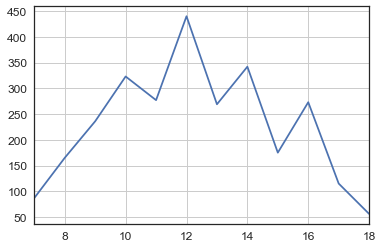

In [15]:
calls_stat_ds['regular_clients'].plot()
plt.grid()
plt.show()